In [9]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

# Loading and chunking log files into episodes

In [3]:
data_dir = '../logs/VizDoom/'
data_files = os.listdir(data_dir)
data = list()
labels = list()

fmt = '{:<20}{}'

for i, file in enumerate(data_files):
    if 'eval' not in file:
        with open(data_dir + file, 'r') as f:
            data.append(f.readlines()[1:])
        if 'online_trial' in file or 'wm' in file:
            if 'VizDoom' in data_dir or 'Padded' in data_dir:
                lab = 'wm ' + file.split('_')[-1].split('.')[0]
            else:
                lab = 'wm'
        elif 'dqn' in file:
            lab = 'dqn ' + file.split('-')[-1].split('.')[0]
        else:
            lab = file.split('-')[0].lower()
        labels.append(lab)
print('Lines per dataset:')
for i in range(len(data)):
    print(fmt.format(labels[i], len(data[i])))

Lines per dataset:
dqn 1               68784
wm 2                132948
wm 4                111744
dqn 3               67884
wm 1                58014
wm 0                68388
dqn 0               134718
wm 3                142230
dqn 4               216336
dqn 2               62046
random              1574520


In [4]:
def chunk(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

chunked_data = list()

print('Episodes per dataset:')
for i, ds in enumerate(data):
    if 'random' in labels[i].lower():
        chunk_size = 5
    else:
        chunk_size = 6
    chunked_data.append(list(chunk(ds, chunk_size)))
    
    print(fmt.format(labels[i], len(chunked_data[i])))

Episodes per dataset:
dqn 1               11464
wm 2                22158
wm 4                18624
dqn 3               11314
wm 1                9669
wm 0                11398
dqn 0               22453
wm 3                23705
dqn 4               36056
dqn 2               10341
random              314904


# Basic analysis of episode rewards

In [5]:
seperator = '-'*114
episode_rewards = dict()

for i, chunked_ds in enumerate(chunked_data):
    print(f'{seperator}\n{labels[i]}\n{seperator}')

    
    episode_rew = [float(epi[1].strip().split(': ')[1]) for epi in chunked_ds]
    episode_rewards[labels[i]] = episode_rew
    
    print('\n' + str(stats.describe(episode_rew)))
    print('\nEpisode where max reward occurred:\n' + \
          ''.join(chunked_ds[np.argmin(episode_rew)]))
    print('\nEpisode where max reward occurred:\n' + \
          ''.join(chunked_ds[np.argmax(episode_rew)]))

------------------------------------------------------------------------------------------------------------------
dqn 1
------------------------------------------------------------------------------------------------------------------

DescribeResult(nobs=11464, minmax=(92.0, 2584.0), mean=374.7720690858339, variance=61854.651262018786, skewness=1.9311258603989385, kurtosis=5.571019978742175)

Episode where max reward occurred:
27/03/2020 20:21:30 - Episode 1457:               
	latest episode reward: 92.0               
	total episode reward: 470055.0               
	average_reward: 322.7767857142857               
	change in average: 0.17678571428569967               
	average Q_loss: 0.2994406844762244


Episode where max reward occurred:
29/03/2020 22:56:25 - Episode 8819:               
	latest episode reward: 2584.0               
	total episode reward: 3215484.0               
	average_reward: 364.3569970514856               
	change in average: 0.0035888627592726152           


DescribeResult(nobs=314904, minmax=(91.0, 1229.0), mean=238.48142608541016, variance=12369.355977431695, skewness=1.1629143254513687, kurtosis=1.684940504659135)

Episode where max reward occurred:
16/01/2020 11:00:25 - Episode 349:               
	latest episode reward: 91.0               
	total episode reward: 80417.0               
	average_reward: 230.82183908045977               
	change in average: -0.16951538639901287


Episode where max reward occurred:
16/01/2020 19:10:04 - Episode 266253:               
	latest episode reward: 1229.0               
	total episode reward: 63478122.0               
	average_reward: 238.4090748614095               
	change in average: 0.0002538616761569301



# Basic analysis of rolling average rewards

In [39]:
seperator = '-'*114
avg_rewards = dict()

conv_rate = 0.01

for i, chunked_ds in enumerate(chunked_data):
    print(f'{seperator}\n{labels[i]}\n{seperator}')
    
    last = list()
    conv_count = 0
    conv_place = 0
    for j, epi in enumerate(chunked_ds):
        if abs(float(epi[4].strip().split(': ')[1])) < conv_rate and j > 5000:
            last.append(epi[4].strip().split(': ')[1])
            conv_count += 1
        else:
            last = list()
            conv_count = 0
            
        if conv_count == 5:
            conv_place = j
            break
            
    if conv_place == 0:
        conv_place = j
    
    avg_rew = [float(epi[3].strip().split(': ')[1]) for epi in chunked_ds]    
    print('\n' + str(stats.describe(avg_rew[:conv_place-1])))
    print('\n' + str(np.std(avg_rew[:conv_place-1])))
    print('\nEpisode where max avg reward occurred:\n' + \
          ''.join(chunked_ds[np.argmax(avg_rew[:conv_place-1])]))
    
    print(len(avg_rew), conv_place)
    print(last)
    
    avg_rewards[labels[i]] = avg_rew[:conv_place-1]

------------------------------------------------------------------------------------------------------------------
dqn 1
------------------------------------------------------------------------------------------------------------------

DescribeResult(nobs=8575, minmax=(0.0, 362.5759064327485), mean=336.8140287923834, variance=690.8643235050416, skewness=-2.1813628342885227, kurtosis=6.761768983389718)

26.282765384125664

Episode where max avg reward occurred:
29/03/2020 20:55:28 - Episode 8551:               
	latest episode reward: 190.0               
	total episode reward: 3100214.0               
	average_reward: 362.5759064327485               
	change in average: 0.053506152013937935               
	average Q_loss: 0.22301397823342334

11464 8576
['0.002743518728266281', '-0.005655581591042846', '-0.00600415738256288', '0.0029768348406946643', '0.0009938644967633081']
---------------------------------------------------------------------------------------------------------------


DescribeResult(nobs=5050, minmax=(0.0, 274.5), mean=233.40720124515326, variance=19.18565130991599, skewness=-30.233878132209362, kurtosis=1599.0383217081232)

4.379709142288188

Episode where max avg reward occurred:
16/01/2020 10:59:48 - Episode 5:               
	latest episode reward: 184.0               
	total episode reward: 1282.0               
	average_reward: 274.5               
	change in average: 14.166666666666686

314904 5051
['-0.008554781251234544', '-0.0034008372016103294', '-0.0045878441981699325', '-0.008546423269791603', '-0.006167272042972627']


# Change In Average

In [13]:
seperator = '-'*114
chg_avg_rewards = dict()

for i, chunked_ds in enumerate(chunked_data):
    print(f'{seperator}\n{labels[i]}\n{seperator}')
    
    last = list()
    conv_count = 0
    conv_place = 0
    for j, epi in enumerate(chunked_ds):
        if abs(float(epi[4].strip().split(': ')[1])) < conv_rate and j > 5000:
            last.append(epi[4].strip().split(': ')[1])
            conv_count += 1
        else:
            last = list()
            conv_count = 0
            
        if conv_count == 5:
            conv_place = j
            break
            
    if conv_place == 0:
        conv_place = j
    
    chg_avg_rew = [float(epi[4].strip().split(': ')[1]) for epi in chunked_ds]
    
    print('\n' + str(stats.describe(chg_avg_rew)))
    print('\nEpisode where max avg reward occurred:\n' + \
          ''.join(chunked_ds[np.argmax(chg_avg_rew)]))
    
    chg_avg_rewards[labels[i]] = chg_avg_rew[:conv_place]

------------------------------------------------------------------------------------------------------------------
dqn 1
------------------------------------------------------------------------------------------------------------------

DescribeResult(nobs=11464, minmax=(-82.5, 328.0), mean=0.03268742193625303, variance=10.354246586905623, skewness=90.89410110507058, kurtosis=9452.510245778403)

Episode where max avg reward occurred:
27/03/2020 11:23:22 - Episode 2:               
	latest episode reward: 163.0               
	total episode reward: 491.0               
	average_reward: 328.0               
	change in average: 328.0               
	average Q_loss: 0

------------------------------------------------------------------------------------------------------------------
wm 2
------------------------------------------------------------------------------------------------------------------

DescribeResult(nobs=22158, minmax=(-7.192307692307679, 127.0), mean=0.017800338629624296, 

# Episode reward plots

Note these are to be taken with a grain of salt due to the heavy smoothing applied. The Average Reward plots below are a much more accurate representation of performance

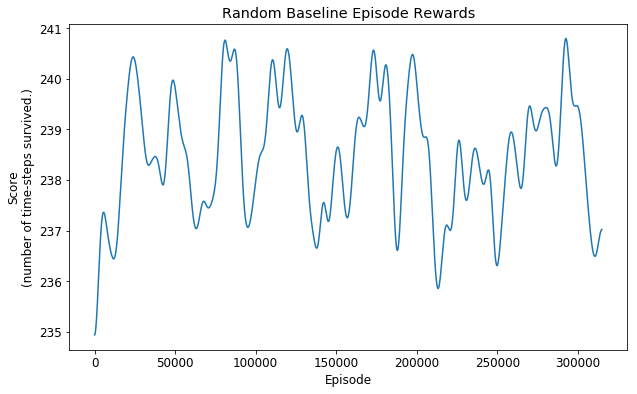

In [56]:
random_smoothed = gaussian_filter1d(episode_rewards['random'], sigma=2500)
plt.title('Random Baseline Episode Rewards')
plt.xlabel('Episode')
plt.ylabel("Score\n(number of time-steps survived.)")
plt.plot(random_smoothed)

In [57]:
dqn_smoothed = gaussian_filter1d(episode_rewards['dqn'], sigma=150)
plt.title('DQN Episode Rewards')
plt.xlabel('Episode')
plt.ylabel("Score\n(number of time-steps survived.)")
plt.plot(dqn_smoothed)

KeyError: 'dqn'

In [ ]:
ddqn_smoothed = gaussian_filter1d(episode_rewards['ddqn'], sigma=150)
plt.title('DDQN Episode Rewards')
plt.xlabel('Episode')
plt.ylabel("Score\n(number of time-steps survived.)")
plt.plot(ddqn_smoothed)

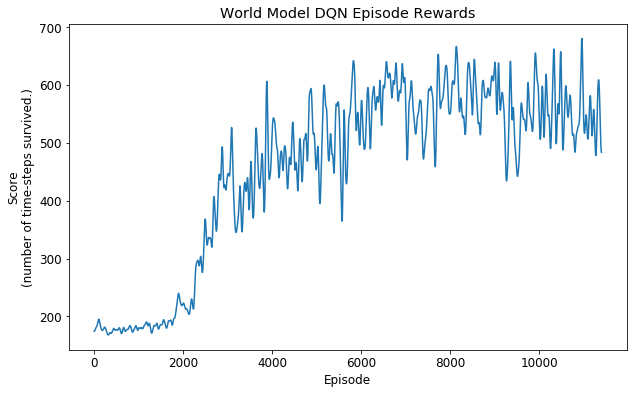

In [121]:
wm_smoothed = gaussian_filter1d(episode_rewards['wm 0'], sigma=20)
plt.title('World Model DQN Episode Rewards')
plt.xlabel('Episode')
plt.ylabel("Score\n(number of time-steps survived.)")
plt.plot(wm_smoothed)

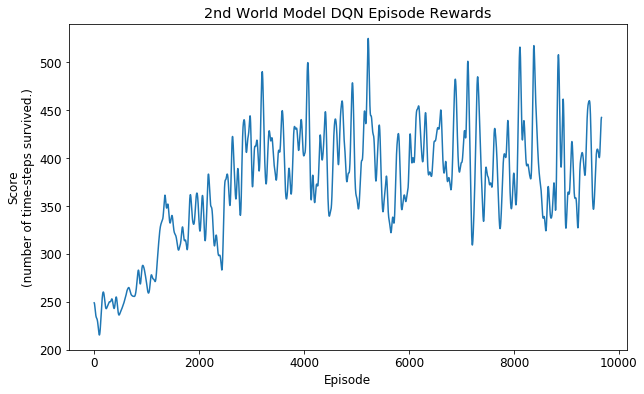

In [122]:
wm_2_smoothed = gaussian_filter1d(episode_rewards['wm 1'], sigma=20)
plt.title('2nd World Model DQN Episode Rewards')
plt.xlabel('Episode')
plt.ylabel("Score\n(number of time-steps survived.)")
plt.plot(wm_2_smoothed)

# Average reward plots

dqn 2
dqn 3
dqn 4
wm 2
wm 3
wm 4
dqn 2 cyan
dqn 3 orange
dqn 4 red
wm 2 blue
wm 3 purple
wm 4 green


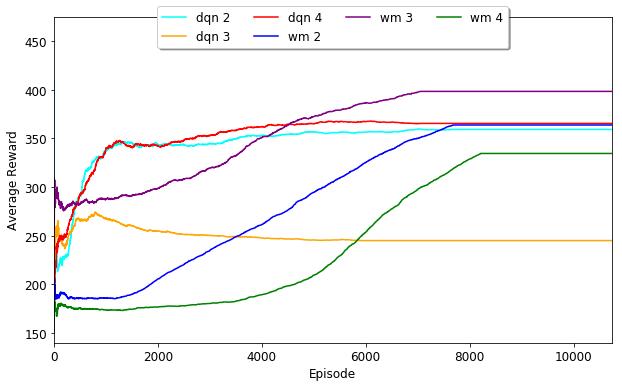

In [40]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

limit = np.max([len(ds) for (lab,ds) in avg_rewards.items() if 'wm' in lab])

lower_bound = 150
upper_bound = float('INF')

from copy import deepcopy
def pad(dataset, length):
    ds = deepcopy(dataset)
    while len(ds) < length:
        ds.append(ds[-1])
    
    return ds

# colors = ['cyan', 'orange', 'red', 'blue', 'purple', 'green']
avg_rewards = dict(sorted(avg_rewards.items()))
wm_vals = [(lab,ds) for (lab, ds) in avg_rewards.items() if 'random' not in lab and int(lab.split(' ')[1]) > 1]

for (lab, d) in wm_vals:
    print(lab)
    
for (label, dataset), color in zip(wm_vals, colors):
    print(label, color)
    clip = np.clip(pad(dataset, limit), lower_bound, upper_bound)
#     if 'wm' in label:
#         color = 'blue'
#     if 'dqn' in label:
#         color = 'orange'
#         else:
#             color = 'black'
    plt.plot(clip, color=color, label=label)
    placement = limit if len(dataset) > limit else len(dataset)-1
#     plt.annotate(f'{label.title()} - {dataset[placement]:.3f}',
#                  (placement, dataset[placement]),
#                  textcoords='offset points', xytext=(7.5,0),
#                  ha='left')

    
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.xlim((0,limit))
plt.ylim((140,475))

# Put a legend below current axis
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='purple', lw=3),
                Line2D([0], [0], color='green', lw=3),
                Line2D([0], [0], color='orange', lw=3)]
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)

# Change in Average Reward Plot

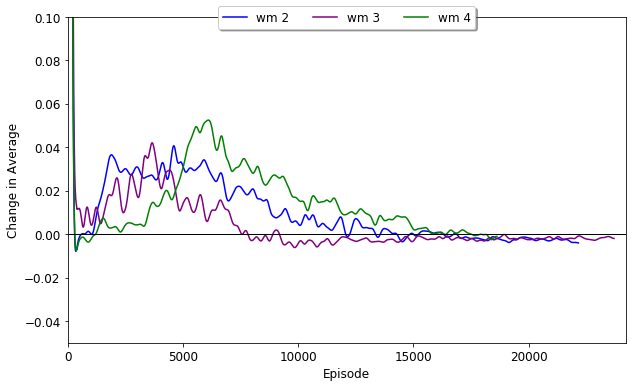

In [16]:
limit = np.max([len(chg_avg_rewards[f'wm {i}']) for i in range(5)])

lower_bound = -.1
upper_bound = .25
sig = 100

colors = ['orange', 'red', 'blue', 'purple', 'green']
chg_avg_rewards = dict(sorted(chg_avg_rewards.items()))
datasets_chg = [(lab,ds) for (lab, ds) in chg_avg_rewards.items() if 'wm' in lab]

for (label, dataset), color in zip(datasets_chg, colors):
    if 'wm' in label and int(label.split(' ')[1]) > 1:
        gaus = gaussian_filter1d(dataset[:limit], sigma=sig)
        clip = np.clip(gaus, lower_bound, upper_bound)
        plt.plot(clip, label=label, color=color)
        placement = limit-1 if len(dataset) > limit else len(dataset)-1
    #     plt.annotate(f'{label}\n{dataset[placement]:.3f}',
    #                  (placement, clip[placement]),
    #                  textcoords='offset points', xytext=(7.5,-10),
    #                  ha='left', color=color)

plt.xlabel("Episode")
plt.ylabel("Change in Average")
plt.ylim((lower_bound, upper_bound))
plt.xlim((0,limit+500))
plt.ylim((-0.05, .10))
plt.axhline(linewidth=1, color='black')

# Put a legend below current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)